In [1]:
import pandas as pd

# Define the data types for each column
column_types = {
    'departamento': 'category',
    'municipio': 'category',
    'sexo': 'category',
    'año_registrado': 'category', 
    'edad': 'int64',  
    'periodo': 'category',
    'etnia': 'category',
    'escolaridad': 'category',
    'ocupacion': 'category',
    'causa': 'category',
    'asistencia': 'category',
    'lugar': 'category'
}

# Read the CSV file and explicitly define the data types
defunciones = pd.read_csv('defunciones_clean.csv', dtype=column_types)

defunciones.head()

# See which columns have missing values
defunciones.isnull().sum()

# Drop rows with missing values
defunciones = defunciones.dropna()

/var/folders/g7/1ym58dj93f13x5_nxk6zr72m0000gn/T/ipykernel_71085/4270252984.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data.groupby('causa').filter(lambda x: len(x) > 10000)


Best Model - Accuracy: 0.4057691026580508


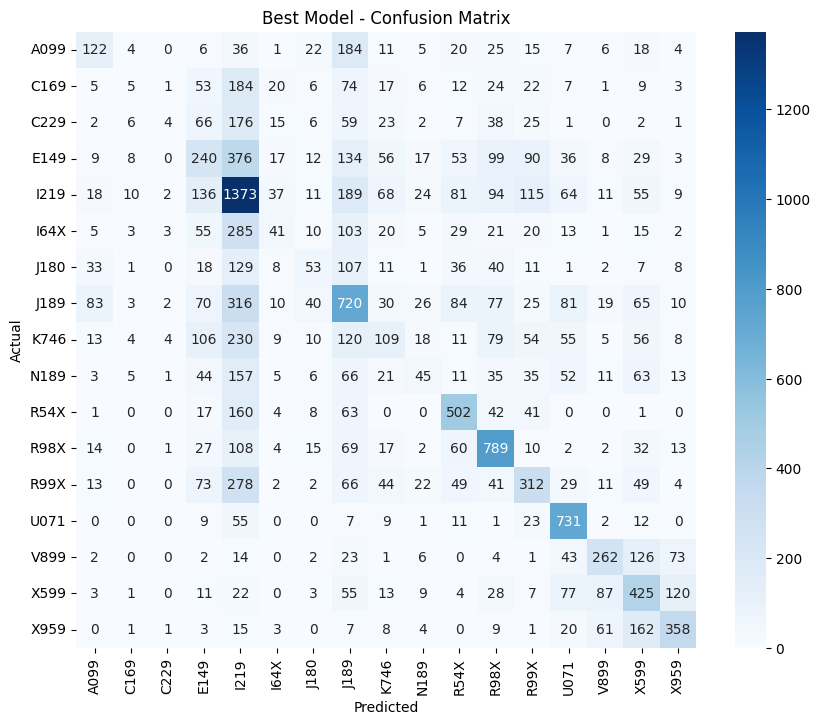

Best Model - Classification Report:
              precision    recall  f1-score   support

        A099       0.37      0.25      0.30       486
        C169       0.10      0.01      0.02       449
        C229       0.21      0.01      0.02       433
        E149       0.26      0.20      0.23      1187
        I219       0.35      0.60      0.44      2297
        I64X       0.23      0.06      0.10       631
        J180       0.26      0.11      0.16       466
        J189       0.35      0.43      0.39      1661
        K746       0.24      0.12      0.16       891
        N189       0.23      0.08      0.12       573
        R54X       0.52      0.60      0.56       839
        R98X       0.55      0.68      0.60      1165
        R99X       0.39      0.31      0.35       995
        U071       0.60      0.85      0.70       861
        V899       0.54      0.47      0.50       559
        X599       0.38      0.49      0.43       865
        X959       0.57      0.55      0.56  

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

data = defunciones.copy()
data = data.groupby('causa').filter(lambda x: len(x) > 10000)

# Reduce the data size
data = data.sample(frac=0.1, random_state=43)

X = data.drop('causa', axis=1)
Y = data['causa']

numerical_columns = ['edad']
categorical_columns = ['departamento', 'municipio', 'sexo', 'año_registrado', 'periodo', 'etnia', 'escolaridad', 'ocupacion', 'asistencia', 'lugar']

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_columns),
        ('cat', cat_transformer, categorical_columns)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(preprocessor.fit_transform(X_train), y_train)

param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['lbfgs', 'saga'],
    'classifier__multi_class': ['multinomial'],
    'classifier__max_iter': [5000]
}

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_resampled, y_train_resampled)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(preprocessor.transform(X_test))
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Model - Accuracy: {accuracy}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Best Model - Confusion Matrix')
plt.show()

# Print classification report
print("Best Model - Classification Report:")
print(classification_report(y_test, y_pred))